In [1]:
import os.path
import sys

import librosa
import pandas
import numpy
import sklearn.decomposition
import seaborn

from matplotlib import pyplot as plt
import librosa.display


In [18]:

sr = 22050
audio_file = 'short.wav'
y, sr = librosa.load(audio_file, sr=sr)


#T = sklearn.decomposition.MiniBatchDictionaryLearning(n_components=16)
T = sklearn.decomposition.NMF(n_components=16)

#S = numpy.abs(librosa.stft(y))

bpm = 130
per_beat = 8
interval = (60/bpm)/per_beat
print(interval, sr*interval)

S = numpy.abs(librosa.feature.melspectrogram(y, hop_length=int(sr*interval), n_mels=128, fmin=200, fmax=8000))
#S = librosa.amplitude_to_db(S)

comps, acts = librosa.decompose.decompose(S, transformer=T, sort=False)



0.057692307692307696 1272.1153846153848


/usr/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 78, 3)
(16, 78)
(16, 78, 3)
(16, 78)


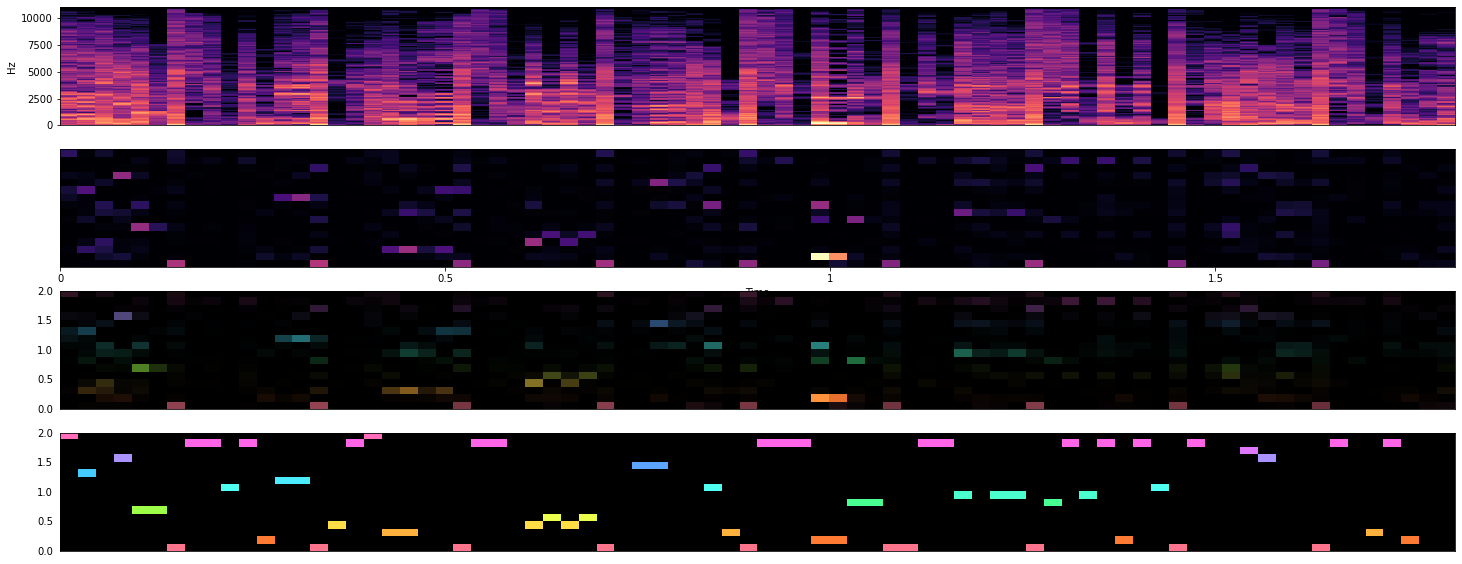

In [19]:

import skimage.io

def plot_colorized_activations(acts, ax, hop_length=None, sr=None, value_mod=1.0):

    #hsv = skimage.color.rgb2hsv(skimage.color.gray2rgb(acts))
    hsv = numpy.stack([
        numpy.ones(shape=acts.shape),
        numpy.ones(shape=acts.shape),
        acts,
    ], axis=-1)
    print(hsv.shape)
    
    colors = seaborn.color_palette("husl", hsv.shape[0])
    for row_no in range(hsv.shape[0]):
        c = colors[row_no]
        c = skimage.color.rgb2hsv(numpy.stack([c]))[0]
        hsv[row_no, :, 0] = c[0]
        hsv[row_no, :, 1] = c[1]
        #hsv[row_no, :, 2] *= value_mod
        hsv[row_no, :, 2] *= value_mod
        #print(colors[row_no])
    
    colored = skimage.color.hsv2rgb(hsv)
    flipped = colored[::-1, :, :]

    print(acts.shape)
    
    ax.imshow(flipped, extent=[0, 32, 0, 2.0])
    #ax.set_xticks(numpy.linspace(0, flipped.shape[1]-1, flipped.shape[1]-1))
    ax.set(aspect='auto')
    
    ax.tick_params(axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)
    
    ax.tick_params(axis='both',
        which='both',
        bottom=False,
        left=False,
        top=False,
        labelbottom=False)
    

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(25, 10), sharex=False)

librosa.display.specshow(librosa.amplitude_to_db(S, ref=numpy.max), ax=ax[0], y_axis='linear')


librosa.display.specshow(acts, x_axis='time', ax=ax[1])

a = pandas.Series(acts.flatten())
threshold = a.quantile(0.90)


#librosa.display.specshow(norm < threshold, x_axis='time', ax=ax[2])

plot_colorized_activations(acts, ax=ax[2], value_mod=3.0)

# thresholded
norm = acts / numpy.quantile(acts, 0.95, axis=0, keepdims=True)
threshold = numpy.quantile(norm, 0.95)
plot_colorized_activations((norm > threshold).astype(float), ax=ax[3], value_mod=1.0)


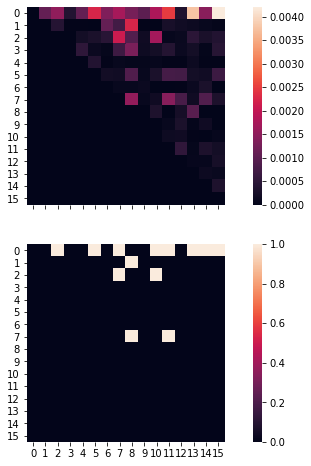

In [4]:
def coactivation_matrix(act):
    s = act.shape[0]
    out = numpy.zeros(shape=(s, s))
    
    for col in act.T:
        main = col.argmax(axis=0)
        #print(col.shape, main)
        #for i, val in enumerate(col):
        #out.append({'main': main, 'other': i, 'val': val})
        
        out[main, :] += col
            
    
    #df = pandas.DataFrame.from_records(out)
    out /= act.T.shape[0] 
    
    return out
    #most_active = acts.argmax(axis=0)
    
coact = coactivation_matrix(acts)
#coact.groupby('main')
#coact.pivot(index=['main', 'other'], columns='val')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharey=True, sharex=True)
upp = numpy.triu(coact, k=1)
seaborn.heatmap(upp, annot=False, fmt='g', ax=ax[0])
ax[0].set_aspect('equal', adjustable='box')

t = numpy.quantile(upp, 0.95)
seaborn.heatmap(upp > t, annot=False, fmt='g', ax=ax[1])
ax[1].set_aspect('equal', adjustable='box')

In [5]:
acts.shape

(16, 78)

In [6]:
covMatrix.shape

NameError: name 'covMatrix' is not defined

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
covMatrix = numpy.cov(acts, bias=False)
seaborn.heatmap(covMatrix, annot=False, fmt='g', ax=ax)
ax.set_aspect('equal', adjustable='box')

In [ ]:
pca = sklearn.decomposition.PCA(n_components=8)

v = numpy.abs(pca.fit_transform(acts.T).T)
print(v.shape)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(25, 8))
librosa.display.specshow(v, x_axis='time', ax=ax[1])
